---
# 0️⃣ Data Load

In [1]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype
from moda.dataprep import raw_to_ts, ts_to_range
import lasio
import math
import joypy
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mode

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import dtw
from dtaidistance import clustering

import time
from datetime import datetime, date, timedelta

import datetime as dt
import urllib
from urllib.error import URLError, HTTPError
import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

## 경고메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore')
## 숨겼던 경고메세지 다시 보이게하기
# warnings.filterwarnings(action='default')

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH = r"F:/YJ-RnDnote-WS/data/"; YJPATH3 = r'F:/YJ-format-230125/data/'
NCPATH = r"C:/app/Git-WS/2022/local-yjtest/23-YJ-RnDnote/YJH-RnDnote-WS/data/"
INDIR = r"001_pbp_raw/" 
OUTDIR = r"002_pbp_interim/"; OUTDIR3 = r'interim/'

kf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')

raw = pd.read_csv(YJPATH + OUTDIR + r'pbp-zone-2023-02-20-2.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')

def two_digit(n): 
    return f"{n:02d}"
raw['bs_cnt']=raw['bs_cnt'].apply(two_digit)

def six_digit(n): 
    return f"{n:06d}"
raw['bso_rcnt']=raw['bso_rcnt'].apply(six_digit)

raw.drop_duplicates(inplace=True)
raw.shape

(1308468, 184)

---
# 1️⃣ Data get Interval

In [2]:
d = datetime.today().date()
pf = pd.read_csv(r'F:/YJ-format-230125/data/interim/pbp-zone-2023-02-21.csv', encoding="cp949", low_memory=False)

pf.drop_duplicates(inplace=True)
pf.shape # 1차 (2030182, 71)

def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d") # game_dt = datetime.strptime(dt, "%Y%m%d").date()
    return game_dt
pf["game_date"] = pf["game_date"].apply(calculate_dt)

## FA 전팀
CATCHER = ['권정웅-65412', '박세혁-62244', '안중열-64022', '박동원-79365', '허도환-77243', '양의지-76232', '유강남-61102', '이재용-67993', '주효상-66354']
TEAM = ['SS', 'DS', 'LG', 'KIA', 'HH', 'NC', 'LG', 'NC', 'WO']
for c, t in zip(CATCHER, TEAM):
    pf['p_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['p_team'])
    pf['a_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['a_team'])
    pf['h_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['h_team'])

---
# 2️⃣ Plotting correlation heatmaps with Seaborn FacetGrid
- https://stackoverflow.com/questions/29592306/plotting-correlation-heatmaps-with-seaborn-facetgrid

### 1) Individual Plot
### 1-1) Inning Frquency per Day

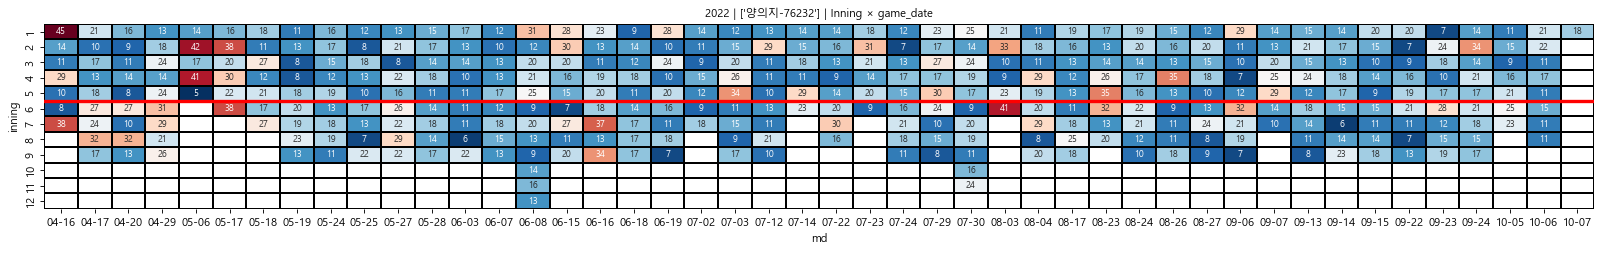

In [4]:
pp = pf.copy()
## -------------------------------------------------- ##
def two_digit(n): return f"{n:02d}"
pp['Week_Number'] = pp['game_date'].dt.isocalendar().week
pp['mm'] = pp['mm'].apply(two_digit)
pp['dd'] = pp['dd'].apply(two_digit)
pp['md'] = pp['mm'] + '-' + pp['dd']

starter = pp.query("inning==1").groupby(['gameID']).agg(cid=('cid', 'first')).reset_index()
starter['catcher_type'] = 'starter'
res = pd.merge(pp, starter, on=['gameID', 'cid'], how='left')

res['catcher_type'] = res['catcher_type'].fillna('closer')

dummy_df = res.query("catcher_type == 'starter' and cid=='양의지-76232' and yy==2022").groupby(['cid', 'md', 'mm', 'dd', 'Week_Number', 'gameID', 'game_date', 'inning']).agg(pitnum=('gid-intot-panum-pitnum', 'count')).reset_index().sort_values('game_date', ascending=True)
le=LabelEncoder()
dummy_df['game_date_le'] = le.fit_transform(dummy_df['game_date'])
dummy_df['game_date_le'] = dummy_df['game_date_le']+1

cid = dummy_df['cid'].unique()
yymmdd= raw.query("cid=='양의지-76232' and yy==2022").groupby(['yy', 'mm', 'dd']).agg(IN=('inning', 'median')).reset_index().sort_values(by=['yy', 'mm', 'dd'], ascending=(True, True, True))
yymm=yymmdd.groupby(['yy', 'mm']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy', 'mm'], ascending=(True, True))
yy= yymm.groupby(['yy']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy'], ascending=(True))
## -------------------------------------------------- ##
ddf = dummy_df.groupby(['md', 'inning']).agg(pitnum=('pitnum', 'median')).reset_index().sort_values('md', ascending=True)
ddf = ddf.pivot('inning', 'md', 'pitnum')

fig=plt.figure(figsize=(25, 3), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(ddf, annot=True, fmt='.0f', cmap='RdBu_r', cbar=False, linewidths=0.005, linecolor="k", annot_kws={"size": 8})
plt.axhline(y=yy.IN.values, color='r', lw=3, linestyle='-')
plt.title('2022 | {} | Inning × game_date'.format(cid), fontsize=10)
plt.show()

### 1-2) Inning Frquency per Week Number

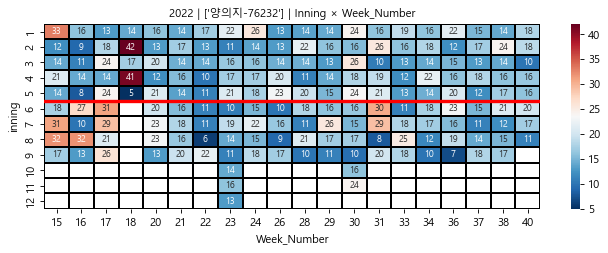

In [5]:
ddf = dummy_df.groupby(['Week_Number', 'inning']).agg(pitnum=('pitnum', 'median')).reset_index().sort_values('Week_Number', ascending=True)
ddf = ddf.pivot('inning', 'Week_Number', 'pitnum')

fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(ddf, annot=True, fmt='.0f', cmap='RdBu_r', cbar=True, linewidths=0.005, linecolor="k", annot_kws={"size": 8})
plt.axhline(y=yy.IN.values, color='r', lw=3, linestyle='-')
plt.title('2022 | {} | Inning × Week_Number'.format(cid), fontsize=10)
plt.show()

### 1-3) Inning Frquency per Month

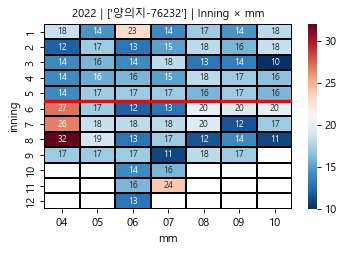

In [6]:
ddf = dummy_df.groupby(['mm', 'inning']).agg(pitnum=('pitnum', 'median')).reset_index().sort_values('mm', ascending=True)
ddf = ddf.pivot('inning', 'mm', 'pitnum')

fig=plt.figure(figsize=(5, 3), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(ddf, annot=True, fmt='.0f', cmap='RdBu_r', cbar=True, linewidths=0.005, linecolor="k", annot_kws={"size": 8})
plt.axhline(y=yy.IN.values, color='r', lw=3, linestyle='-')
plt.title('2022 | {} | Inning × mm'.format(cid), fontsize=10)
plt.show()

### 2) Multiple Plot
### 2-1) each row per plot

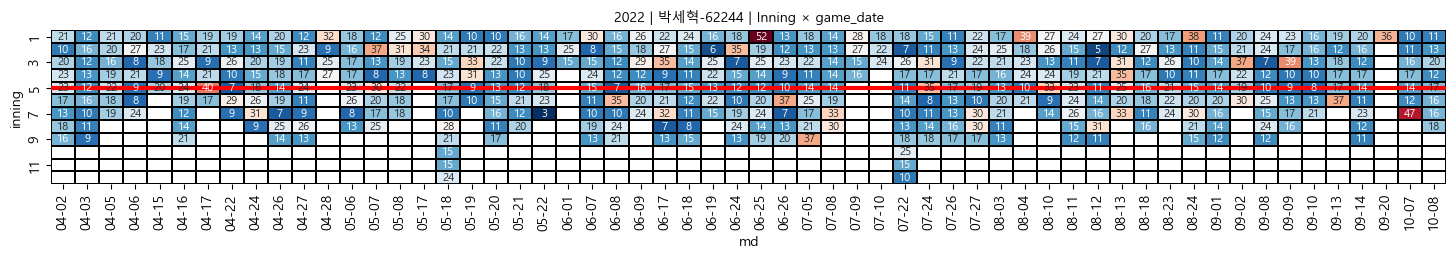

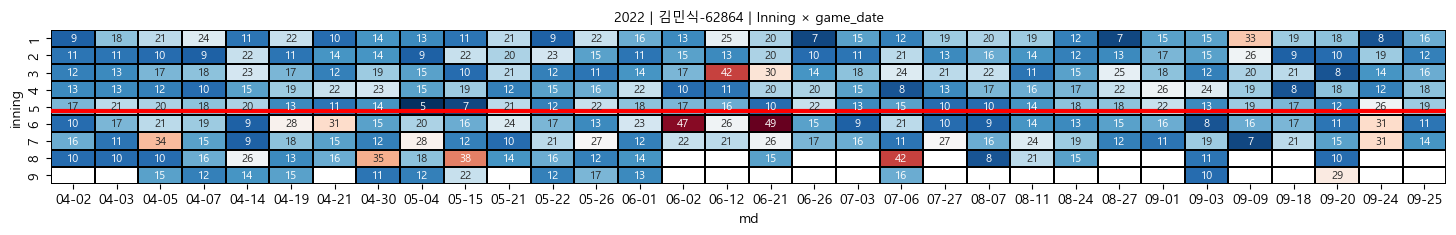

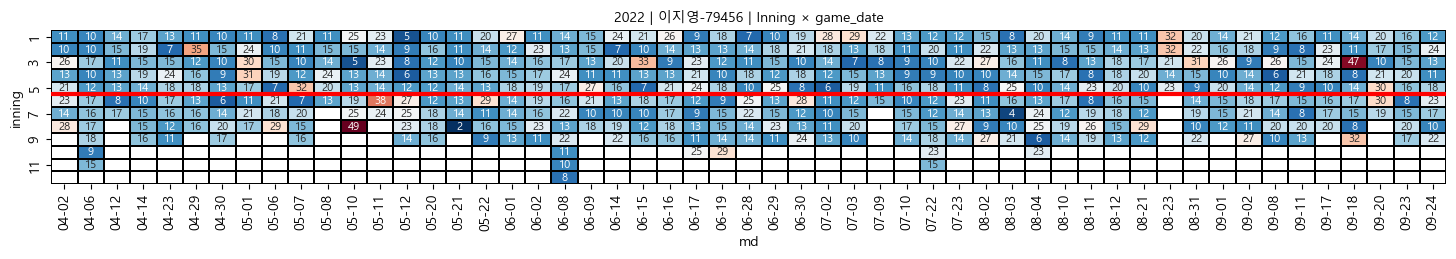

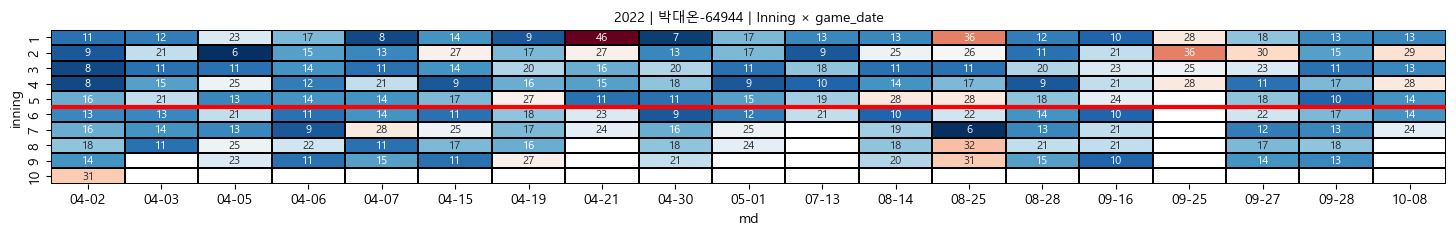

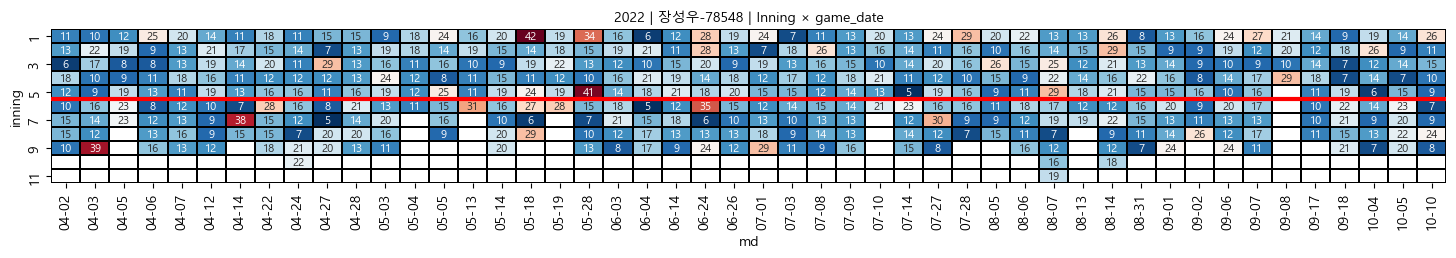

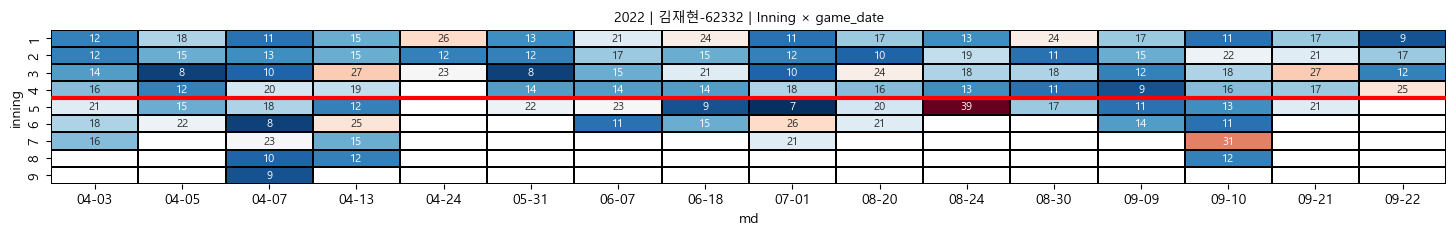

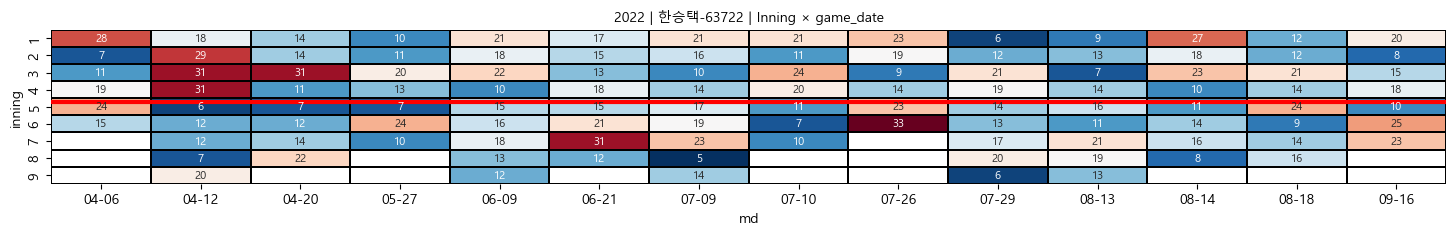

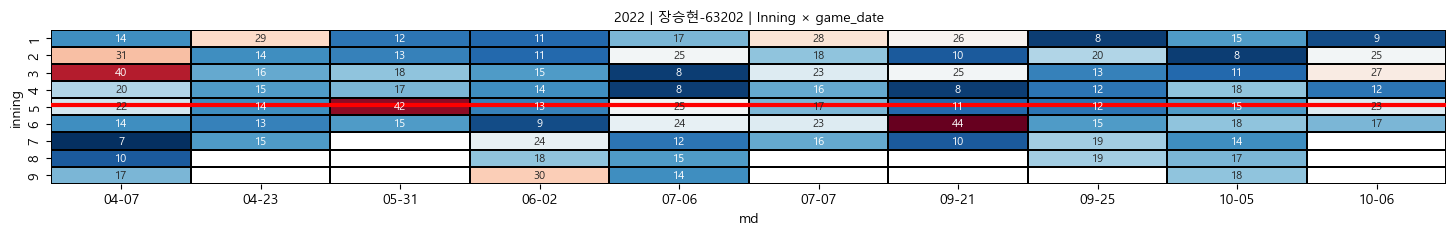

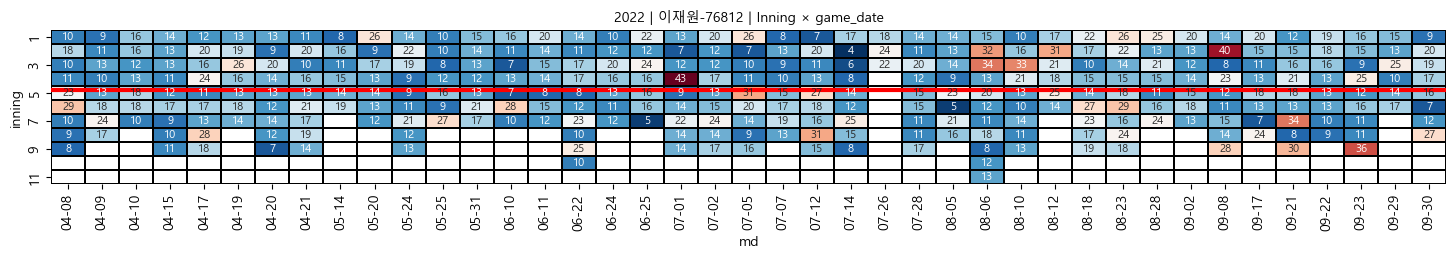

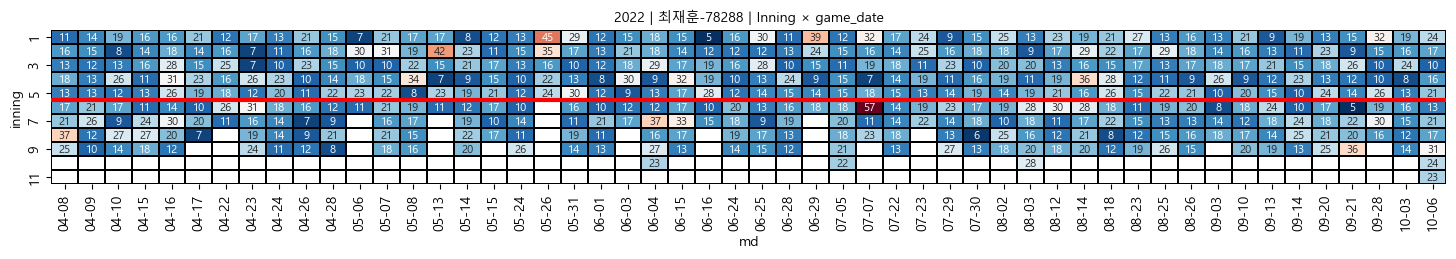

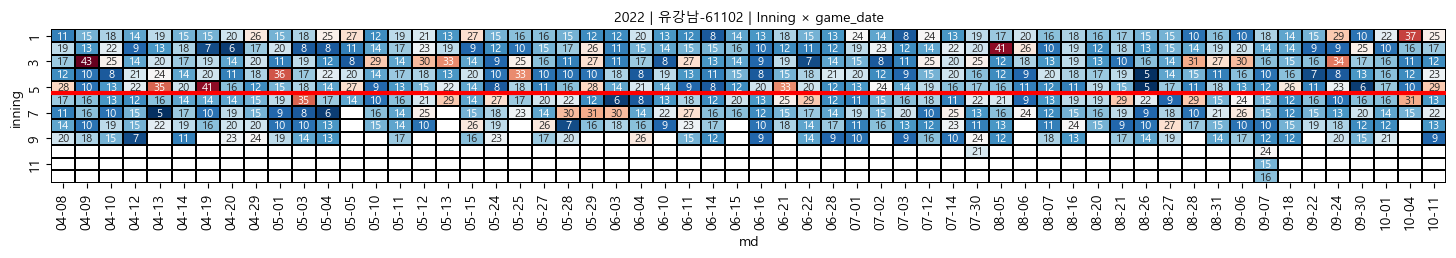

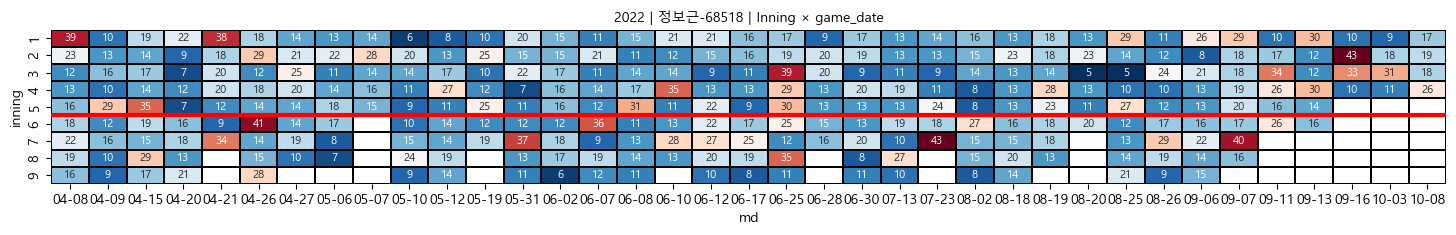

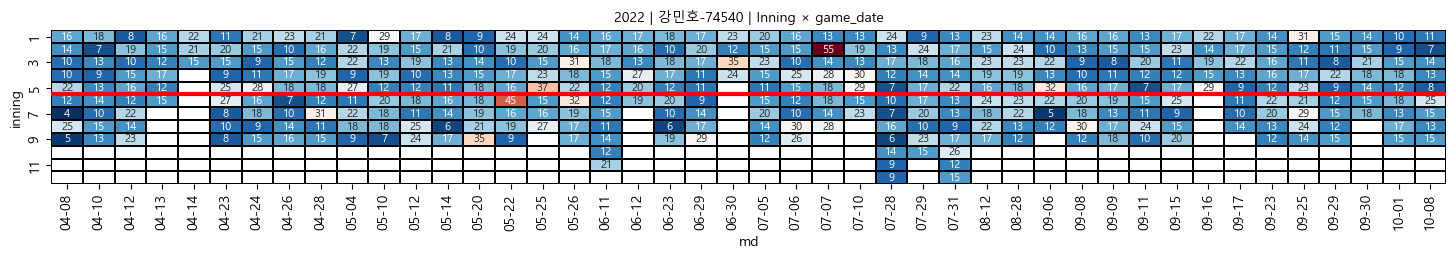

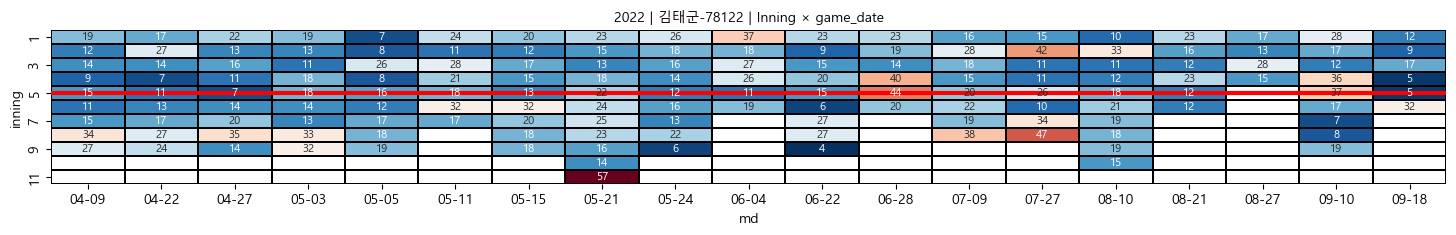

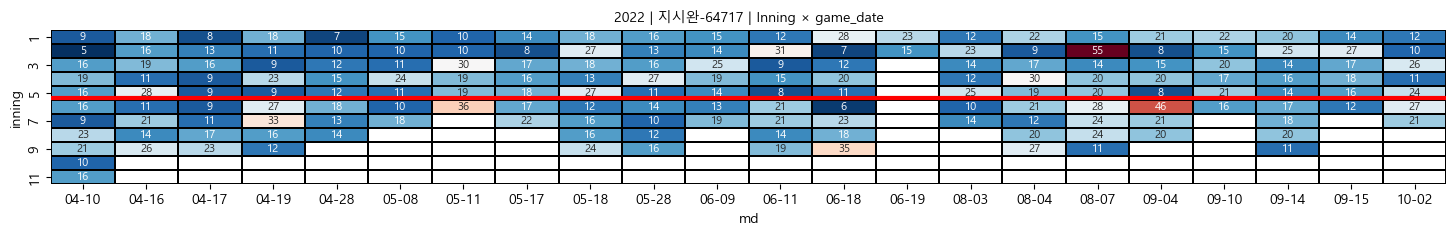

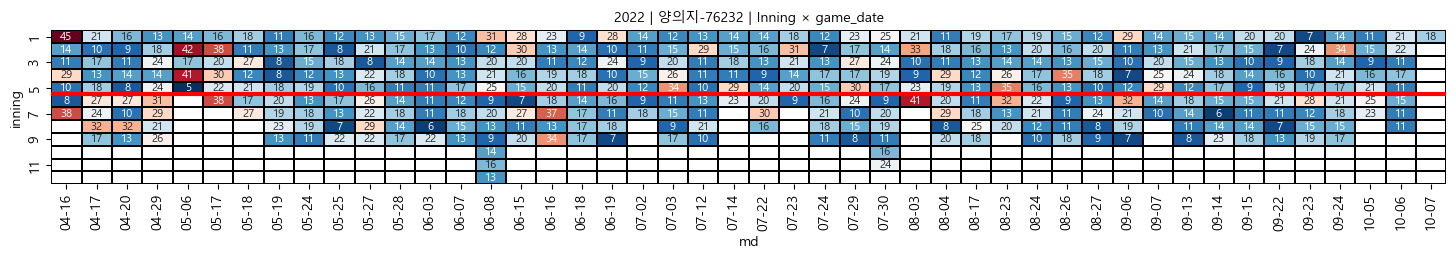

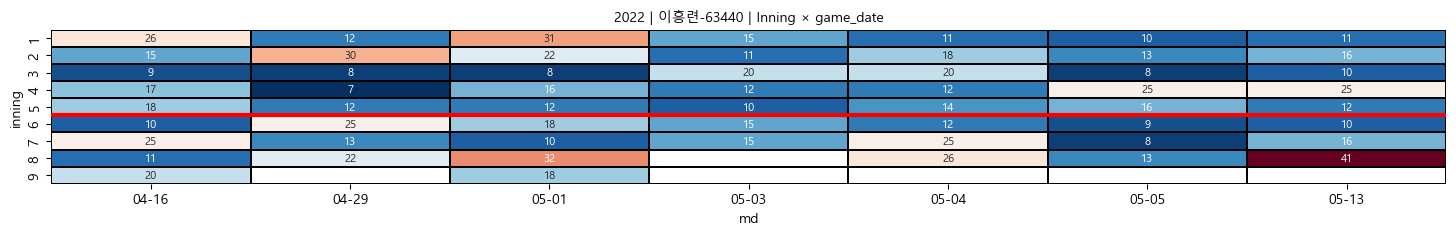

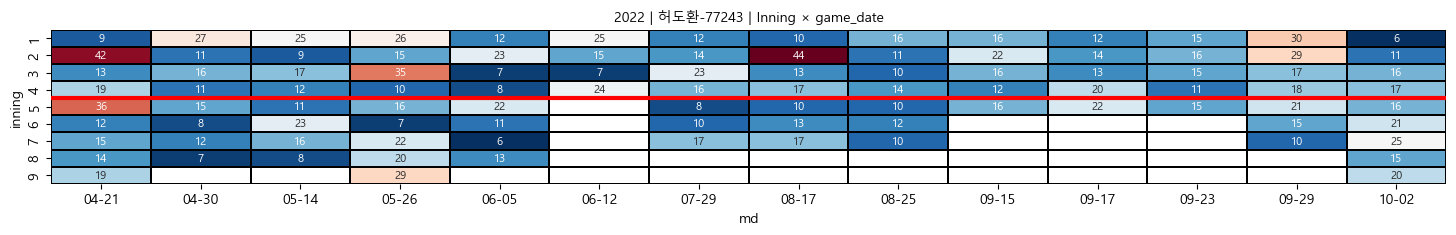

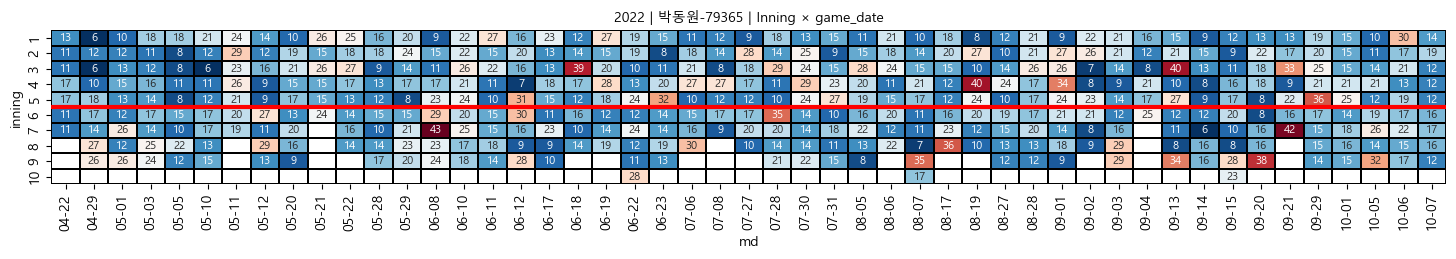

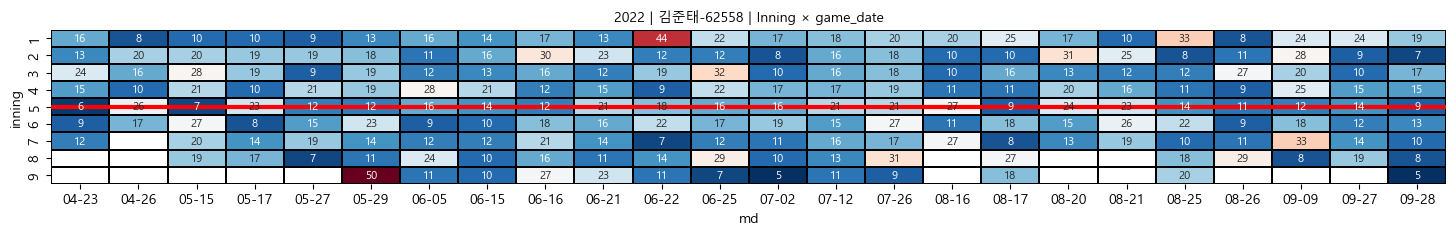

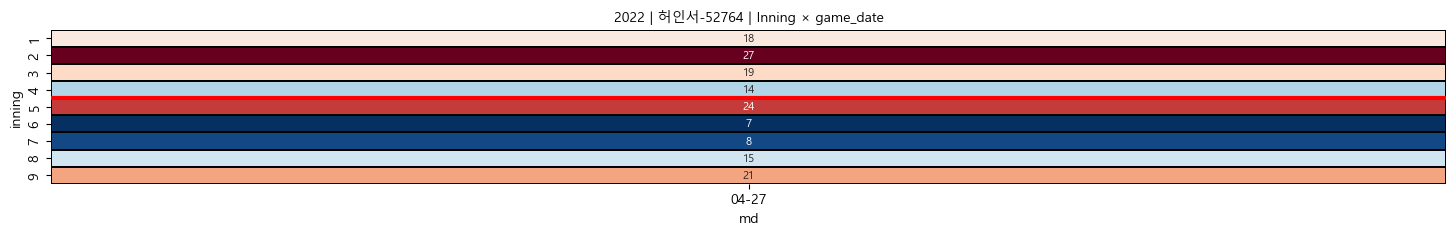

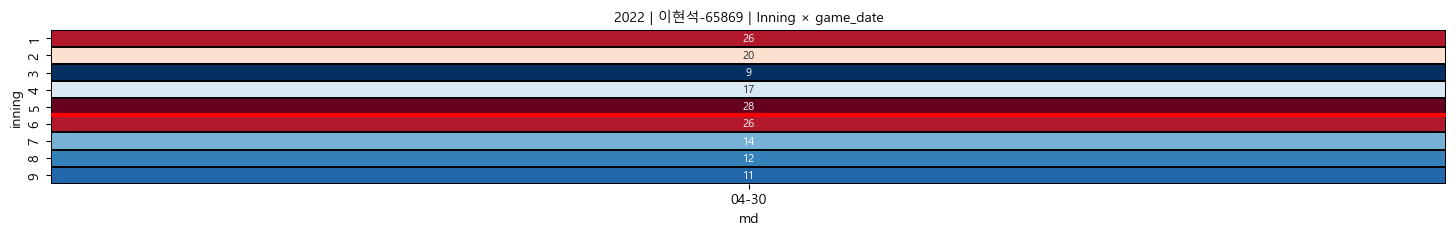

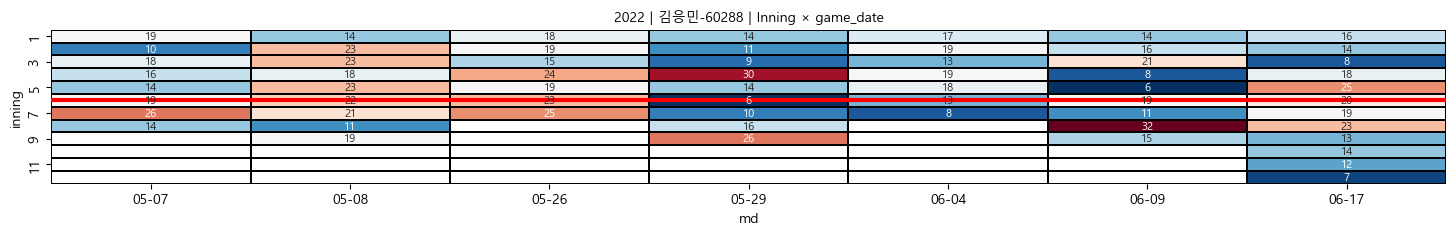

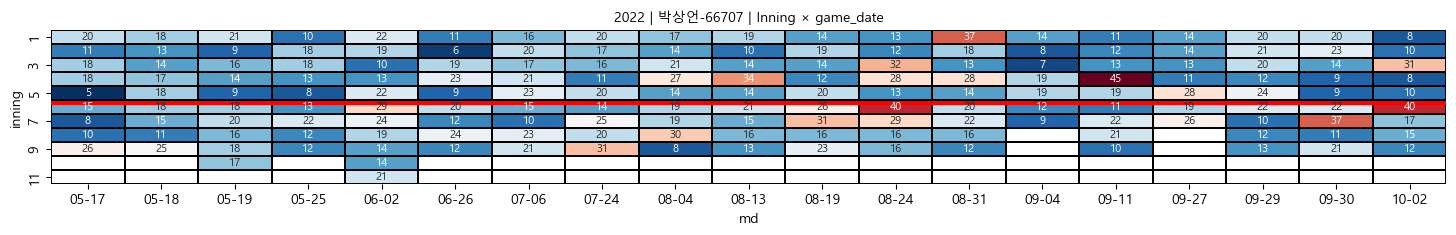

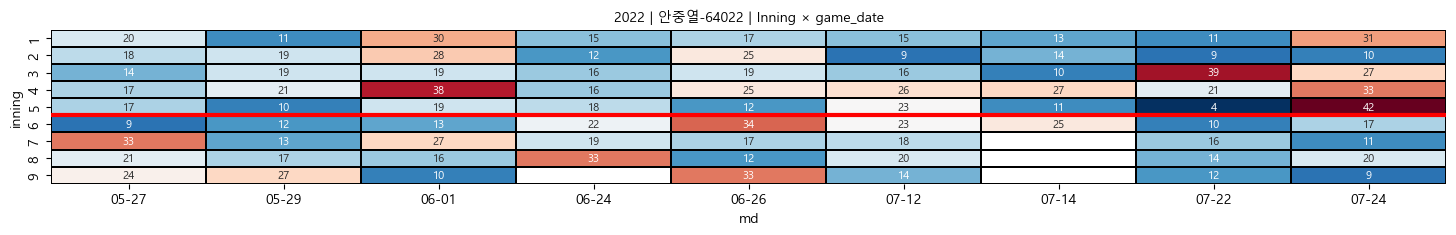

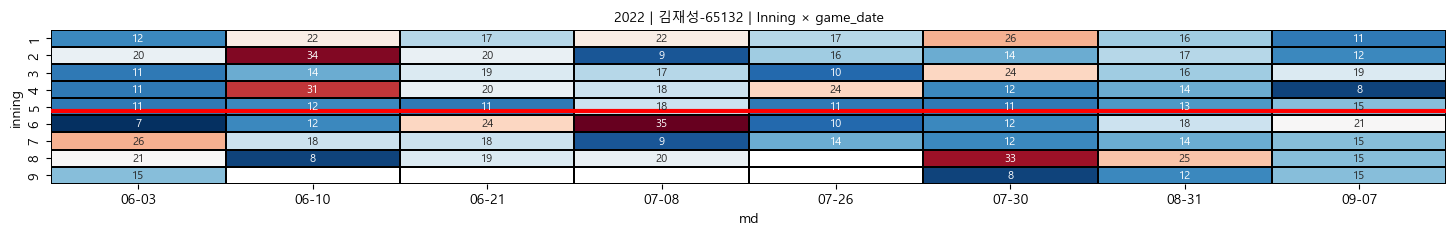

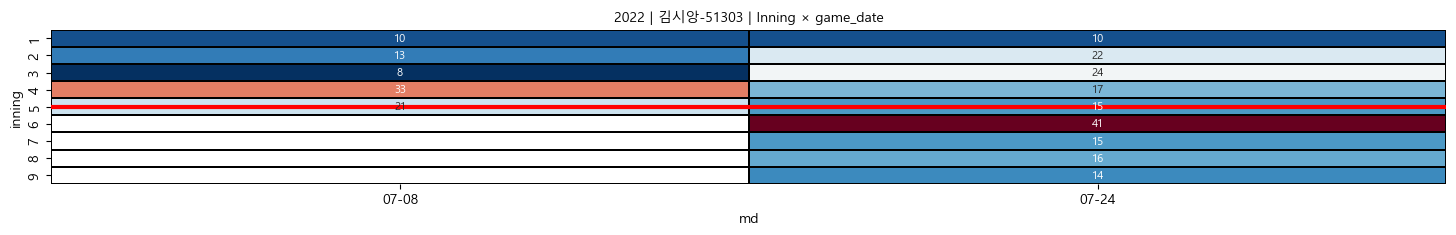

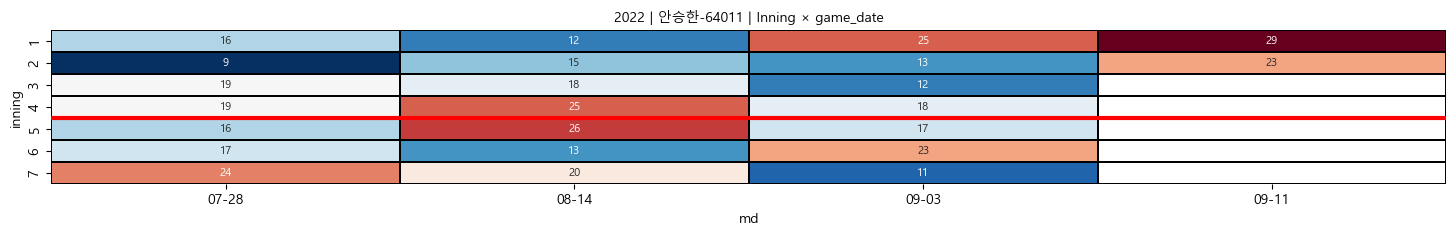

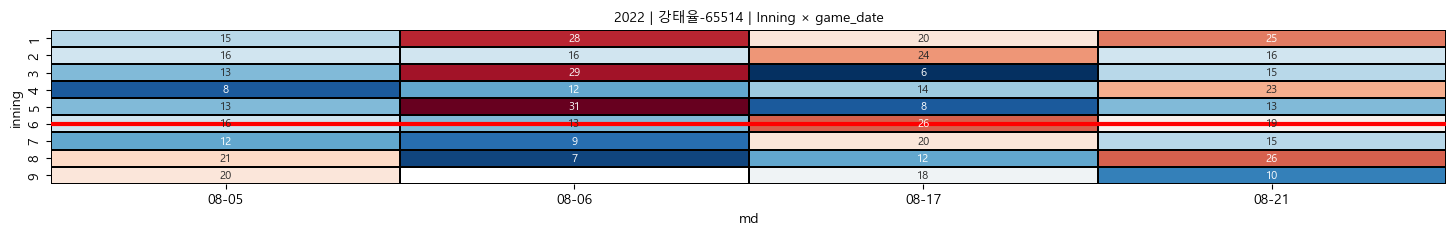

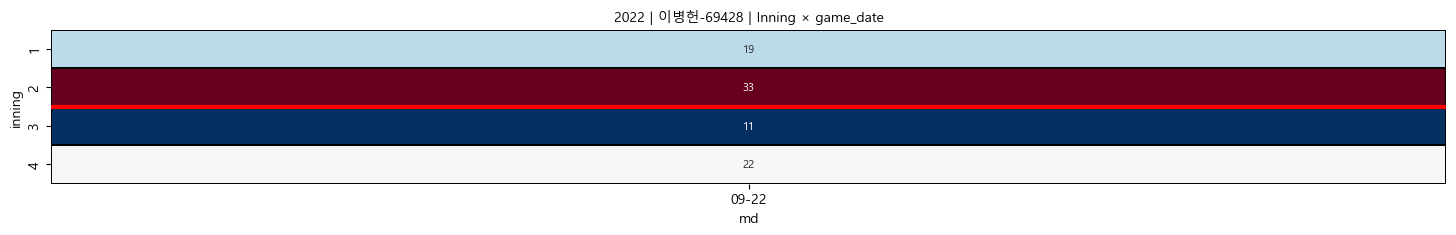

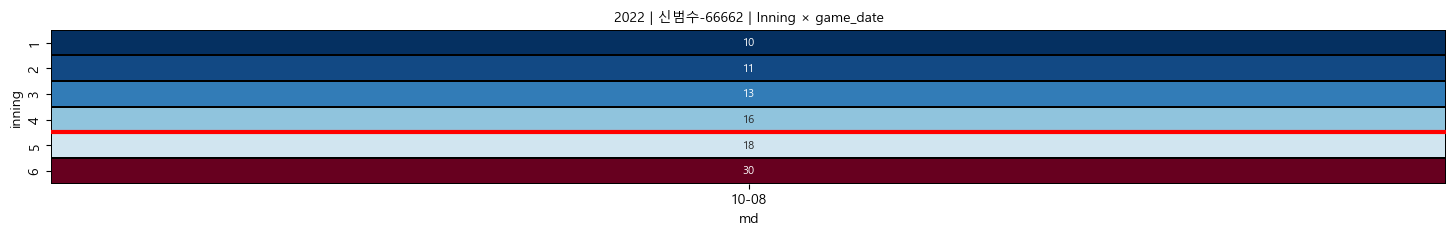

In [15]:
pp = pf.copy()

def two_digit(n): return f"{n:02d}"
pp['Week_Number'] = pp['game_date'].dt.isocalendar().week
pp['mm'] = pp['mm'].apply(two_digit)
pp['dd'] = pp['dd'].apply(two_digit)
pp['md'] = pp['mm'] + '-' + pp['dd']

## -------------------------------------------------- ##
starter = pp.query("inning==1").groupby(['gameID']).agg(cid=('cid', 'first')).reset_index()
starter['catcher_type'] = 'starter'
res = pd.merge(pp, starter, on=['gameID', 'cid'], how='left')

## -------------------------------------------------- ##
res['catcher_type'] = res['catcher_type'].fillna('closer')

## -------------------------------------------------- ##
gid = res.query("yy==2022").groupby(['cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])
gid['score'] = gid_bins
gid = gid[['cid','score']]
ress=pd.merge(res, gid, on='cid', how='left')

## -------------------------------------------------- ##
cid = ress.query("catcher_type=='starter' and yy==2022")['cid'].unique()
for c in cid:
    resc = ress.query("catcher_type=='starter' and yy==2022").sort_values(by='game_date', ascending=True)
    resc = resc.query("cid=='{}'".format(c)).sort_values('score', ascending=True)

    dummy_df = resc.groupby(['cid', 'p_team', 'mm', 'Week_Number', 'dd', 'md', 'gameID', 'game_date', 'inning'])\
    .agg(pitnum=('gid-intot-panum-pitnum', 'count'), score=('score', 'first')).reset_index().sort_values(by=['score', 'game_date'], ascending=(True, True))
    
    yymmdd= ress.query("catcher_type=='starter' and cid=='{}' and yy==2022".format(c)).groupby(['yy', 'mm', 'dd']).agg(IN=('inning', 'median')).reset_index().sort_values(by=['yy', 'mm', 'dd'], ascending=(True, True, True))
    yymm=yymmdd.groupby(['yy', 'mm']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy', 'mm'], ascending=(True, True))
    yy= yymm.groupby(['yy']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy'], ascending=(True))
    
    ddf = dummy_df.groupby(['md', 'inning']).agg(pitnum=('pitnum', 'median')).reset_index().sort_values('md', ascending=True)
    ddf = ddf.pivot('inning', 'md', 'pitnum')
    
    fig = plt.figure(figsize=(18,2), facecolor='w', edgecolor='k')
    sns.heatmap(ddf, linecolor="k", annot_kws={"size": 8}, annot=True, fmt='.0f', cmap='RdBu_r', linewidths=0.005, cbar=False)
    plt.axhline(y=yy.IN.values, color='r', lw=3, linestyle='-')
    plt.title('2022 | {} | Inning × game_date'.format(c), fontsize=10)
    plt.show()

### 2-2) Complex Heatmap

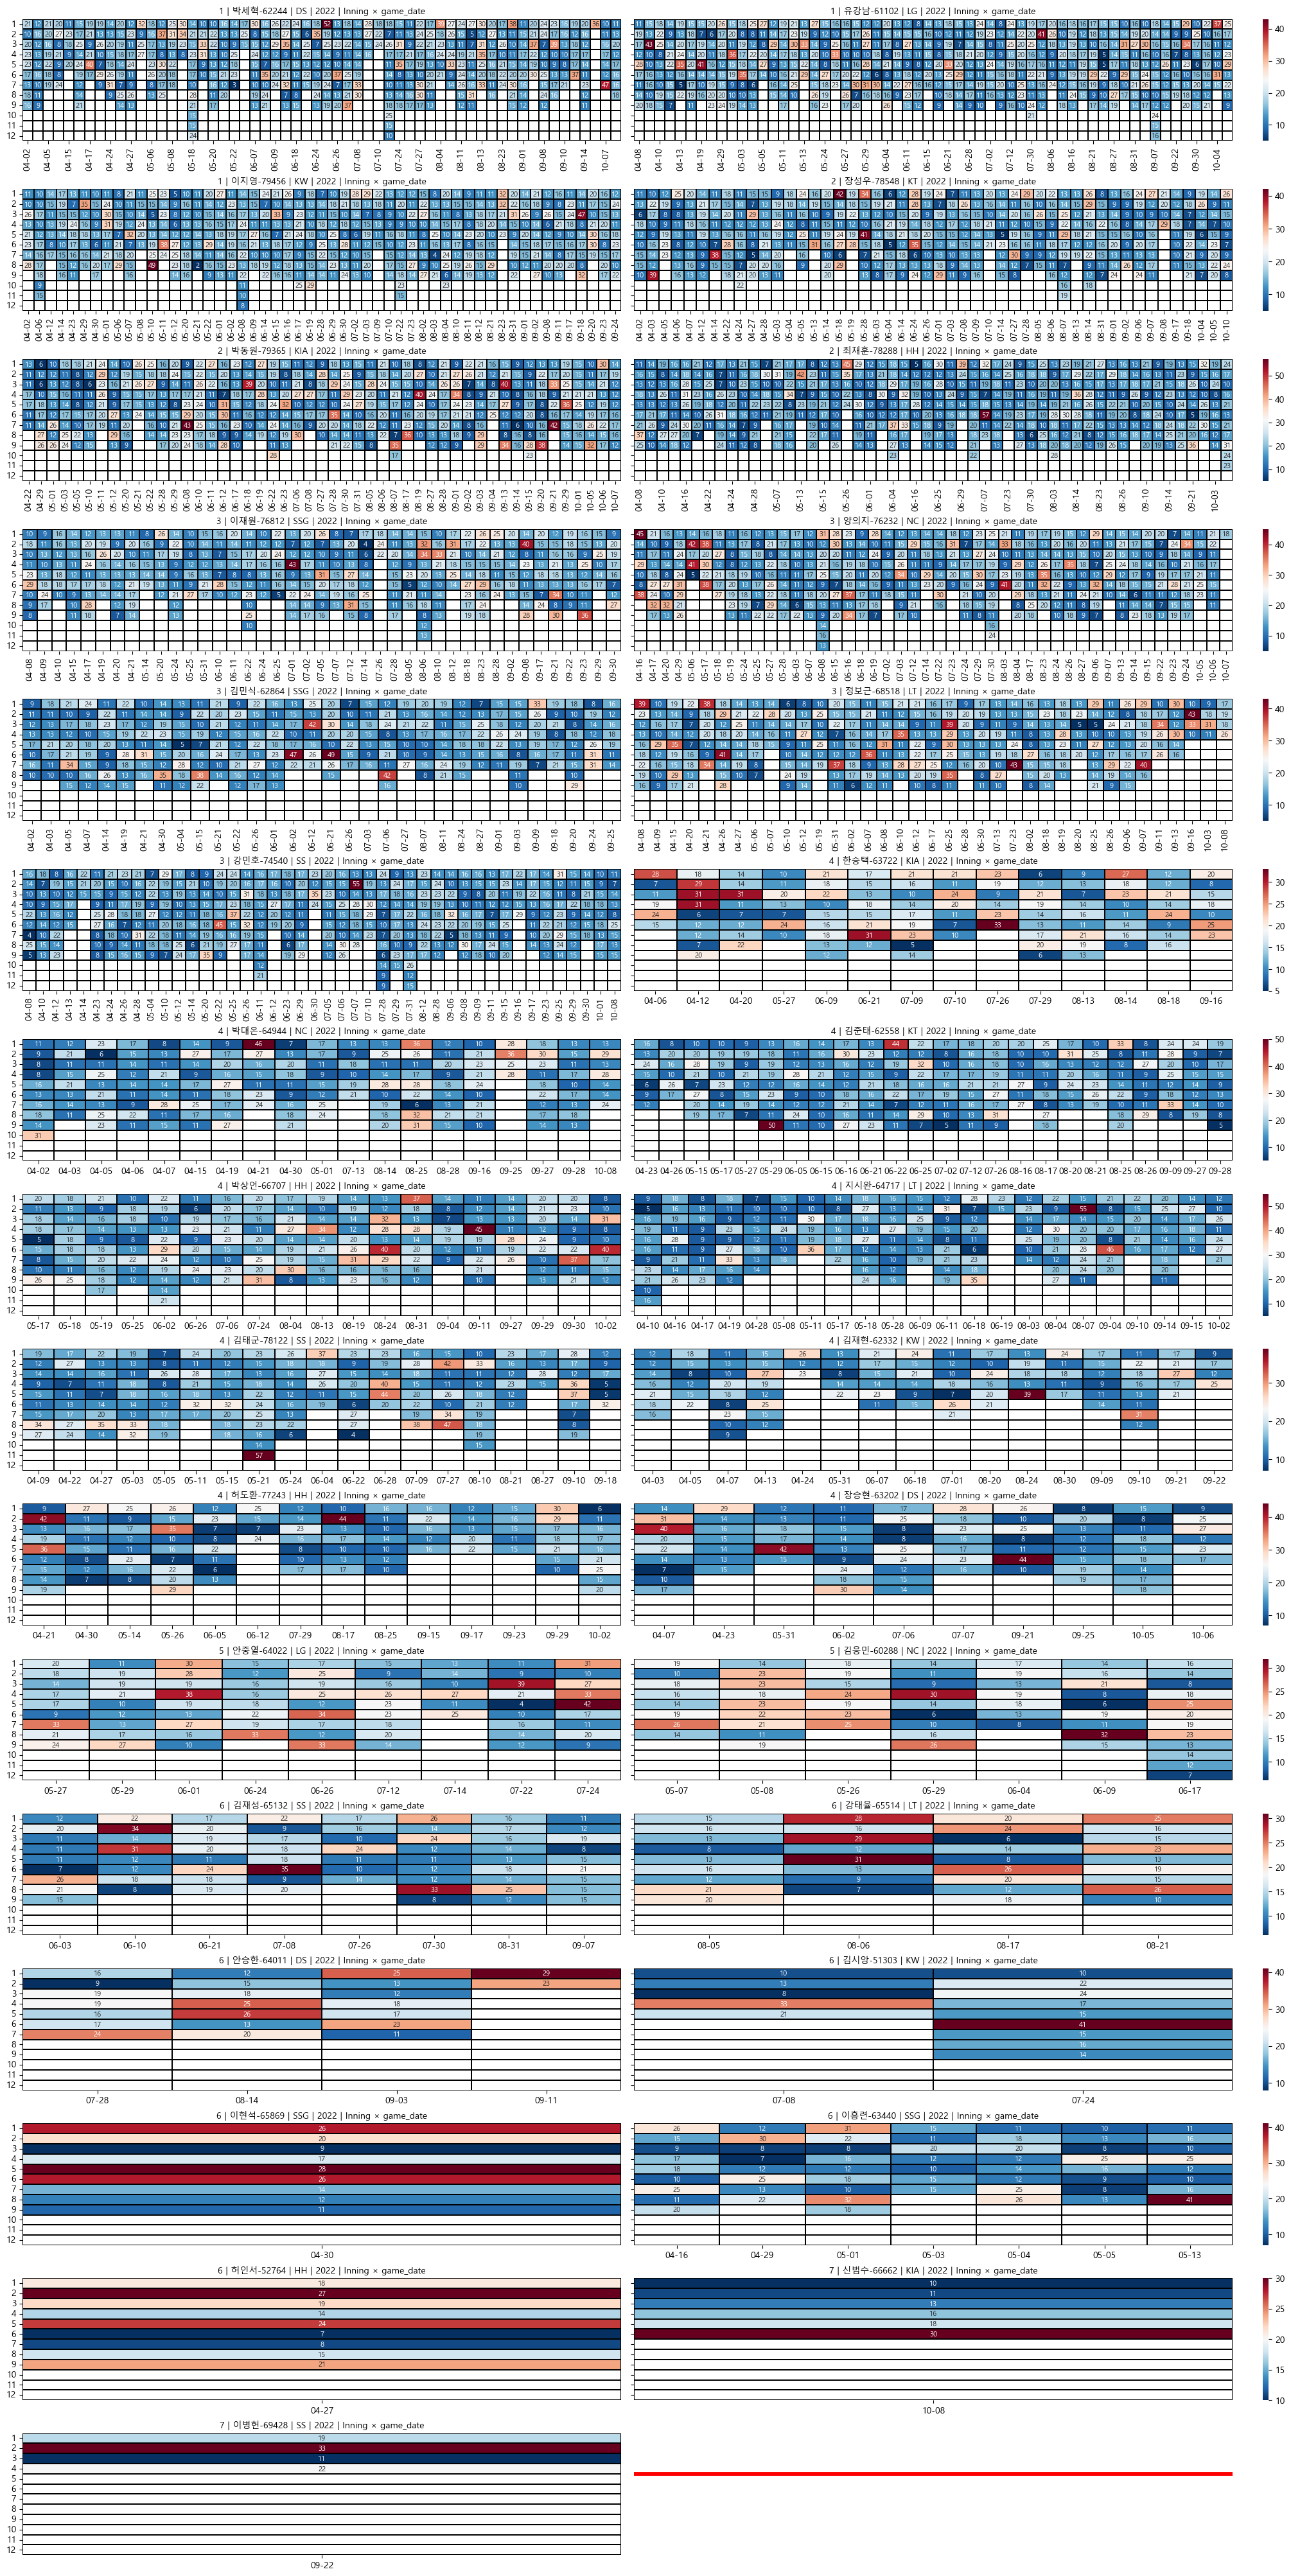

In [101]:
pp = pf.copy()

def two_digit(n): return f"{n:02d}"
pp['Week_Number'] = pp['game_date'].dt.isocalendar().week
pp['mm'] = pp['mm'].apply(two_digit)
pp['dd'] = pp['dd'].apply(two_digit)
pp['md'] = pp['mm'] + '-' + pp['dd']

## -------------------------------------------------- ##
starter = pp.query("inning==1").groupby(['gameID']).agg(cid=('cid', 'first')).reset_index()
starter['catcher_type'] = 'starter'
res = pd.merge(pp, starter, on=['gameID', 'cid'], how='left')
res['catcher_type'] = res['catcher_type'].fillna('closer')

## -------------------------------------------------- ##
gid = res.query("yy==2022").groupby(['cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])
gid['score'] = gid_bins
gid = gid[['cid','score']]
ress=pd.merge(res, gid, on='cid', how='left')

## -------------------------------------------------- ##
yymmdd = ress.query("catcher_type=='starter' and cid=='{}' and yy==2022".format(c)).groupby(['yy', 'mm', 'dd']).agg(IN=('inning', 'median')).reset_index().sort_values(by=['yy', 'mm', 'dd'], ascending=(True, True, True))
yymm = yymmdd.groupby(['yy', 'mm']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy', 'mm'], ascending=(True, True))
yy = yymm.groupby(['yy']).agg(IN=('IN', 'median')).reset_index().sort_values(by=['yy'], ascending=(True))

resc = ress.query("catcher_type=='starter' and yy==2022").sort_values(by='game_date', ascending=True)
resc = resc.sort_values('score', ascending=True)
resc['score'] = resc['score'].astype(int)

dummy_df = resc.groupby(['cid', 'p_team', 'mm', 'Week_Number', 'dd', 'md', 'gameID', 'game_date', 'inning'])\
.agg(pitnum=('gid-intot-panum-pitnum', 'count'), score=('score', 'first')).reset_index().sort_values(by=['score', 'game_date'], ascending=(True, True))
df2 = dummy_df[['cid', 'p_team', 'score', 'md', 'inning', 'pitnum']]

nrows = 16; ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40), sharey=True, constrained_layout=True)
axs = axs.flatten()
catcherID = df2.sort_values('score', ascending=True)['cid'].unique()
df2 = df2.sort_values(by = ['score', 'pitnum'], ascending = (True, False))

def catcher_heatmap(cid, ax, cbar=False, ylabel=False):
    pteam = df2[df2['cid'] == cid]['p_team'].unique(); pteam = pteam[0]
    score = df2[df2['cid'] == cid]['score'].unique(); score = score[0]
    
    dfn = df2[df2['cid'] == cid].sort_values(by = ['score'], ascending = True)
    dfn = dfn.groupby(['inning', 'md']).mean()['pitnum'].unstack()
    dfn = dfn.reindex([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    sns.heatmap(data=dfn, linecolor="k", annot_kws={"size": 8}, annot=True, fmt='.0f', cmap='RdBu_r', linewidths=0.005,  ax=ax, cbar=cbar)
    plt.axhline(y=yy.IN.values, color='r', lw=3, linestyle='-')
    ax.set_title('{} | {} | {} | 2022 | Inning × game_date'.format(score, cid, pteam), fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel("")
    ax.set_xlabel("")

for i, n in enumerate(catcherID): 
    catcher_heatmap(n, axs[i], cbar=i%ncols==ncols-1, ylabel=i%ncols==0)
for j in range(len(catcherID), ncols*nrows):
    axs[j].axis("off")

plt.show()

---
# 9️⃣ REF
- https://stackoverflow.com/questions/43363389/share-axis-and-remove-unused-in-matplotlib-subplots

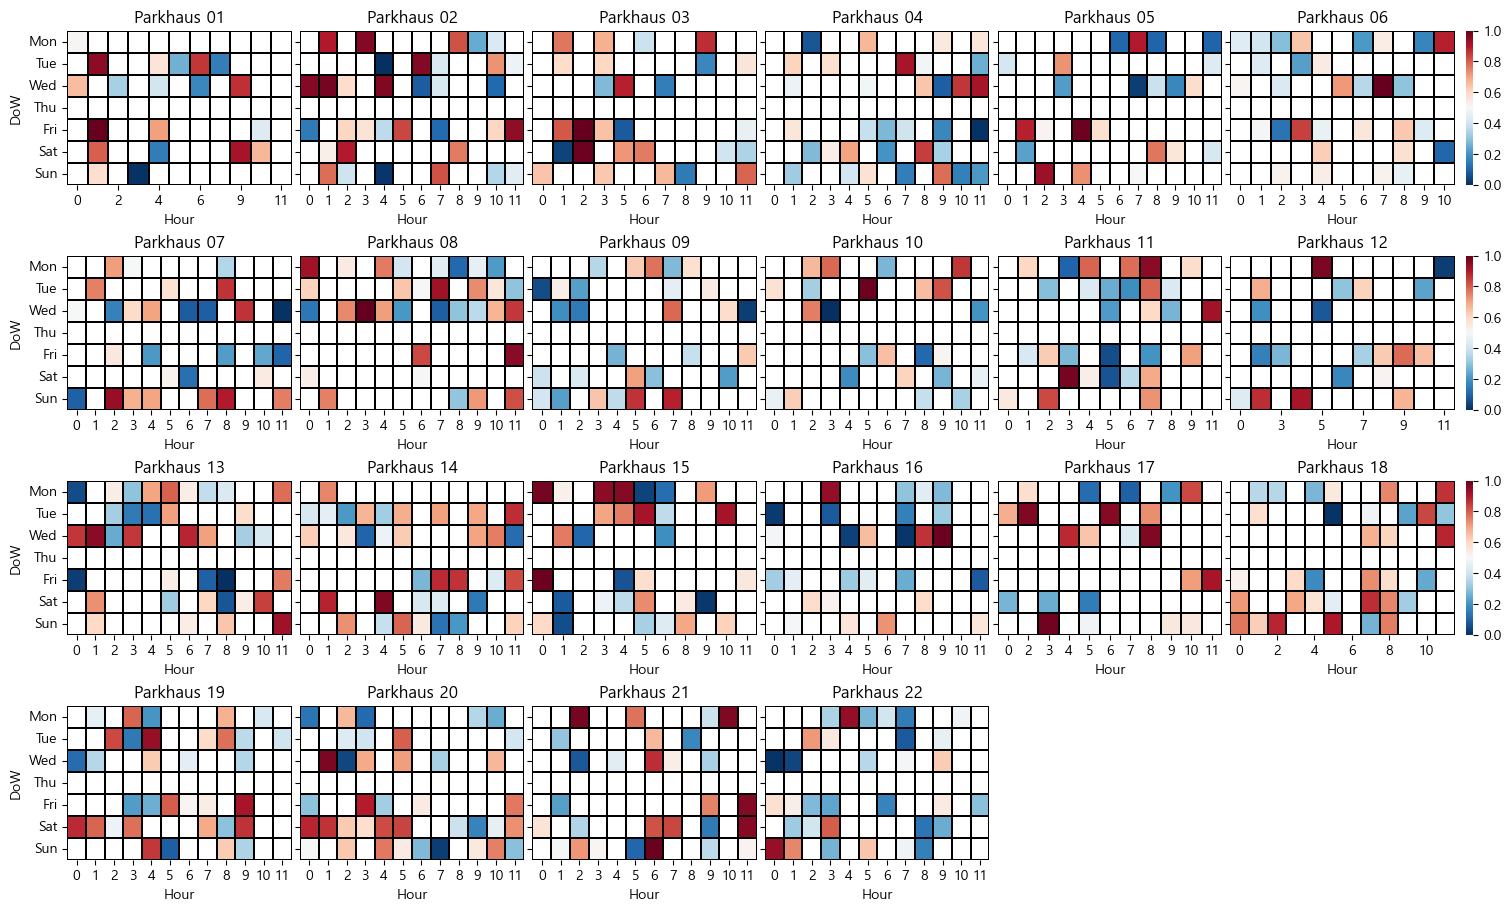

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

days = ['Mon','Tue','Wed','Thurs','Fri','Sat','Sun']
names = ["Parkhaus {:02}".format(i+1) for i in range(22)]

nItems = 1000

df = pd.DataFrame()
df['name'] = [names[i] for i in np.random.randint(0,len(names),nItems)]
df['openLots'] = np.random.randint(0,100,nItems)
df['occupationRatio'] = np.random.rand(nItems)
df['DoW'] = [days[i] for i in np.random.randint(0,7,nItems)]
df['Hour'] = np.random.randint(0,12,nItems)

df2 = df[['name','openLots','occupationRatio','DoW','Hour']]
nrows = 4; ncols=6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,9), sharey=True, constrained_layout=True, facecolor='w', edgecolor='k')
axs = axs.flatten()
locations = df2['name'].sort_values().unique()


def occupation_heatmap (name, ax, cbar=False, ylabel=False):
    dfn = df2[df2['name'] == name]
    dfn = dfn.groupby(['DoW', 'Hour']).mean()['occupationRatio'].unstack()
    dfn = dfn.reindex(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])
    sns.heatmap(data=dfn, vmin=0, vmax=1.0, cmap='RdBu_r', linecolor="k", linewidths=0.005, ax=ax, cbar=cbar)
    ax.set_title(name)
    plt.setp(ax.get_yticklabels(), rotation=0)
    if not ylabel: ax.set_ylabel("")


for i, n in enumerate(locations): 
    occupation_heatmap (n, axs[i], cbar=i%ncols==ncols-1, ylabel=i%ncols==0)
for j in range(len(locations), ncols*nrows):
    axs[j].axis("off")

# plt.tight_layout()
plt.show()

https://stackoverflow.com/questions/43363389/share-axis-and-remove-unused-in-matplotlib-subplots